In [ ]:
import rioxarray
import os
import glob

# 打印指定路径下的所有数据结构
data_path = r'D:\xarray\pre-process'

# 列出目录中的所有文件和文件夹
print("Files and directories in", data_path, ":")
for item in os.listdir(data_path):
    item_path = os.path.join(data_path, item)
    if os.path.isdir(item_path):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")

# 列出所有GeoTIFF文件
geotiff_files = glob.glob(os.path.join(data_path, "*.tif"))
print("\nGeoTIFF files found:")
for file in geotiff_files:
    print(f"- {os.path.basename(file)}")

# 如果有GeoTIFF文件，加载第一个并显示其结构
if geotiff_files:
    print("\nLoading first GeoTIFF file for structure analysis...")
    da = rioxarray.open_rasterio(geotiff_files[0])
    
    # 打印概览
    print("\nData overview:")
    print(da)
    
    # 查看维度、坐标
    print("\nDimensions:", da.dims)
    print("Coordinates:", da.coords)
    
    # 查看元数据
    print("\nMetadata:")
    print("CRS:", da.rio.crs)
    print("Transform:", da.rio.transform())
    print("NoData value:", da.rio.nodata)
    print("Attributes:", da.attrs)
else:
    print("\nNo GeoTIFF files found in the directory.")


In [ ]:
import xarray as xr
ds=xr.open_dataset(r'D:\xarray\final_mask_1km_new.nc')

population=xr.open_dataset(r'D:\xarray\population_density_simple.nc')

ds['final_mask'].values[0,0]



In [ ]:
lat_resolution=ds.lat.values[1]-ds.lat.values[0]
lon_resolution=ds.lon.values[1]-ds.lon.values[0]
print(lat_resolution,lon_resolution)

p_lat_resolution=population.lat.values[1]-population.lat.values[0]
p_lon_resolution=population.lon.values[1]-population.lon.values[0]
print(p_lat_resolution,p_lon_resolution)





In [ ]:
# Plot the result with coarsening to improve visualization
import matplotlib.pyplot as plt

# Define coarsening factor
coarsen_factor = 5  # Adjust this value based on your data resolution

# Coarsen the data for better visualization
pop_coarse = population['pop_density_2020'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()
mask_coarse = ds['final_mask'].coarsen(lat=coarsen_factor, lon=coarsen_factor).mean()

# Create a vertical layout (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Plot coarsened population density
pop_map = pop_coarse.plot(ax=axes[0], cmap='viridis')
axes[0].set_title('Population Density 2020 (Coarsened)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(pop_map, ax=axes[0], label='Population Density')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot coarsened final mask
mask_map = mask_coarse.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Final Mask (Coarsened)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(mask_map, ax=axes[1], label='Mask Value')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the valid data in 'ds'
import numpy as np

valid_count = (~np.isnan(ds['final_mask'])).sum().item()
total_count = ds['final_mask'].size
valid_percentage = (valid_count / total_count) * 100

print(f"Valid data points in final_mask: {valid_count:,} out of {total_count:,} total points")
print(f"Percentage of valid data: {valid_percentage:.2f}%")


In [ ]:
import datetime as dt
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig, CatalogueEnvironment

# Create a link to the CLMS catalogue
config = CatalogueConfig.from_environment(CatalogueEnvironment.CGLS)
catalogue = Catalogue(config)

# Optionally list all collections (title and identifier) available in the catalogue
for c in list(catalogue.get_collections()):  
    print(f"{c.properties.get('title')} | {c.id}")

In [ ]:
import datetime as dt
import os
from tqdm import tqdm

# 你要下载的产品ID
product_id = "clms_global_gdmp_1km_v2_10daily_netcdf"

# 四季代表日期
season_days = {
    "spring": (3, 21),
    "summer": (6, 21),
    "autumn": (9, 23),
    "winter": (12, 21)
}

# 下载根目录
base_dir = r"pre-process\Gross_productivity"  # 修改为你想保存的根目录
os.makedirs(base_dir, exist_ok=True)

# 创建年份和季节的组合列表用于进度条
total_items = len(range(2000, 2023)) * len(season_days)
progress_bar = tqdm(total=total_items, desc="Downloading data")

for year in range(2000, 2023):
    for season, (month, day) in season_days.items():
        try:
            date = dt.date(year, month, day)
            products = list(catalogue.get_products(
                product_id,
                start=date,
                end=date
            ))
            if products:
                # 直接下载到base_dir并重命名
                for product in products:
                    catalogue.download_product(product, base_dir)
                    print(f"Saved")
            else:
                print(f"No products found for {year} {season}")
        except Exception as e:
            print(f"Error for {year}-{season}: {e}")
        
        progress_bar.update(1)

progress_bar.close()

# 数据预处理

一、创建master栅格用于对齐数据

操作逻辑：

1、空间范围一致：lat,lon经纬度一致
1、分辨率一致
3、坐标系一致
4、栅格对齐
5、没有栅格空洞



## 标准栅格创建与修正
不太想重新采样撂荒计算数据，把标准栅格的基座对齐到final_mask

数据输入：
    final：这是根据土地利用（撂荒）产生的mask数据
    master：这是根据美国人口统计产生的陆域bool数据

数据输出：
    r"D:\xarray\aligned\master_land_mask_on_final.nc"
    
    注：这个文件命名有点分辨不清，后期已经重命名为D:\xarray\aligned\master_land_0509.nc




In [9]:
import xarray as xr
MASTER = r"D:\xarray\master_land_mask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask  

master


<xarray.DataArray 'land_mask' (lat: 21600, lon: 43200)> Size: 933MB
[933120000 values with dtype=bool]
Coordinates:
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B ...
Attributes:
    description:  True where population density is valid

In [11]:
import xarray as xr
from pathlib import Path
import numpy as np

MASTER = r"D:\xarray\master_land_mask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
OUT    = r"D:\xarray\aligned\master_land_mask_on_final.nc"

# 1) 读取
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask          # (lat, lon 或 y,x)

# 2) 若 final 用 y/x → 改成 lat/lon（不依赖 rioxarray）
if {"x","y"}.issubset(final.dims):
    final = final.rename({"x":"lon", "y":"lat"})

# 3) 对齐：最近邻插值到 final 网格
# 将布尔类型转换为数值类型，因为interp只能处理数值类型数组
master_numeric = master.astype("uint8")  # 将布尔值转换为0和1
aligned = master_numeric.interp(
    lon=final.lon, lat=final.lat, method="nearest"
).astype("uint8")

# 4) 保留 0/1，写 NetCDF
aligned.to_dataset(name="land_mask").to_netcdf(
    OUT, encoding={"land_mask":{"zlib":True,"complevel":4}}
)

print("✓ 新 land_mask 已输出:", OUT)


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


✓ 新 land_mask 已输出: D:\xarray\aligned\master_land_mask_on_final.nc


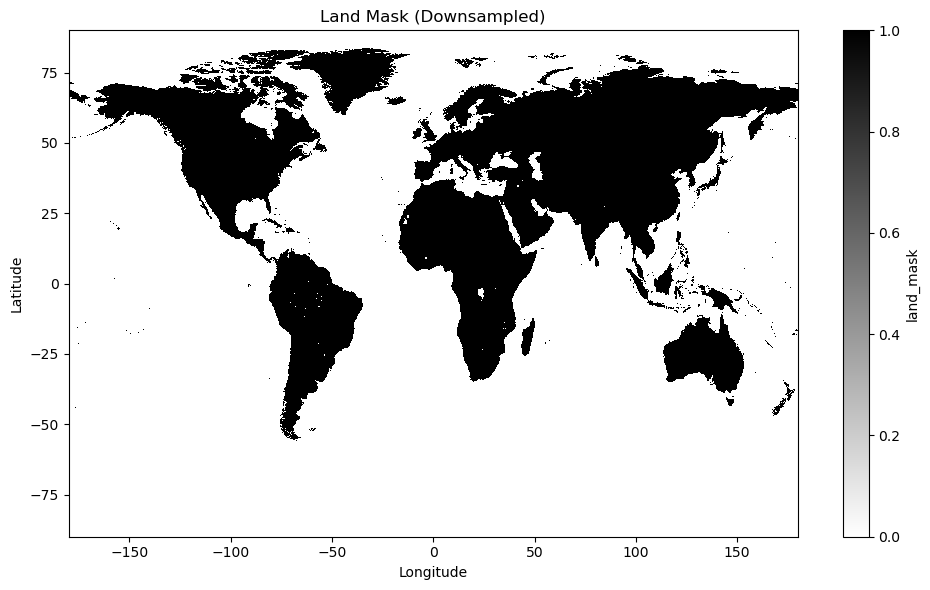

Dataset shape: (21600, 43200)
Data type: uint8


In [15]:
newmaster_path = r'D:\xarray\aligned\master_land_0509.nc'

newmaster = xr.open_dataset(newmaster_path)

import matplotlib.pyplot as plt

# The dataset is too large to plot directly, so we'll downsample it
# Downsample the data to avoid memory error
n = 10  # Adjust this value based on your memory constraints
downsampled = newmaster.land_mask.isel(lat=slice(None, None, n), lon=slice(None, None, n))

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the downsampled data with simple colors
downsampled.plot(ax=ax, cmap='binary', add_colorbar=True)

# Add basic title and labels
plt.title('Land Mask (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Display basic information about the dataset
print(f"Dataset shape: {newmaster.land_mask.shape}")
print(f"Data type: {newmaster.land_mask.dtype}")


### 标准栅格检查结果（没问题）
分辨率比较:
newmaster 经度分辨率: 0.008333333333325754 度
newmaster 纬度分辨率: 0.008333333333354176 度
final_mask 经度分辨率: 0.008333333333325754 度
final_mask 纬度分辨率: 0.008333333333354176 度
分辨率比例 (newmaster/final_mask) - 经度: 1.00x
分辨率比例 (newmaster/final_mask) - 纬度: 1.00x

数据集形状:
newmaster: FrozenMappingWarningOnValuesAccess({'lon': 43200, 'lat': 21600})
final_mask variables: ['final_mask']
final_mask land_mask shape: (21600, 43200)

## 气候TIFF预处理

Number of bands: 1
Raster shape: (20880, 43200)
Raster data type: uint16
Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888885002, right=179.99985967115003, top=83.99986041514998)
CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223600004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


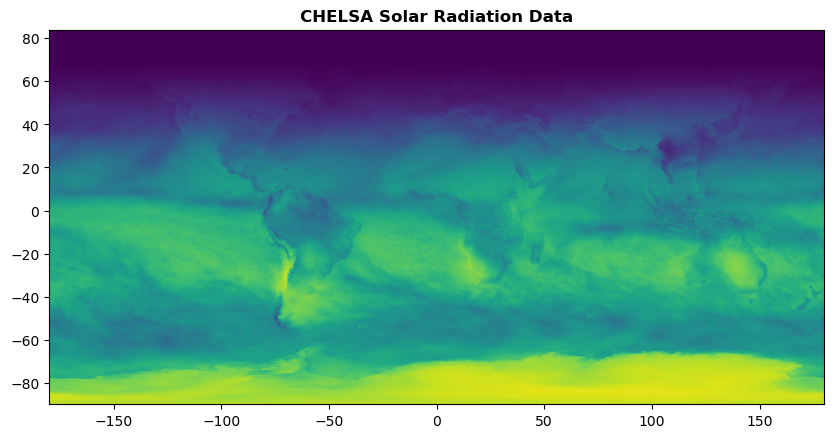

<Figure size 640x480 with 0 Axes>

In [21]:
raster_path = r'D:\xarray\pre-process\Climate\CHELSA_rsds_2000_01_V.2.1.tif'

# 读取tif文件
import rasterio
from rasterio.plot import show

# 打开tif文件
with rasterio.open(raster_path) as src:
    # 显示波段数量
    print(f"Number of bands: {src.count}")
    
    # 读取数据
    raster_data = src.read(1)  # 读取第一个波段
    
    # 显示基本信息
    print(f"Raster shape: {raster_data.shape}")
    print(f"Raster data type: {raster_data.dtype}")
    print(f"Bounds: {src.bounds}")
    print(f"CRS: {src.crs}")
    
    # 可视化
    plt.figure(figsize=(10, 6))
    show(src, title="CHELSA Solar Radiation Data")
    plt.tight_layout()
    plt.show()


### 气候预处理小样本

    根据以上元数据信息，发现坐标、经纬度、分辨率多少都有点不一样。
    

In [43]:
# align_to_master_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np

# ── 配置 ─────────────────────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_PATH = r"D:\xarray\pre-process\Climate\CHELSA_rsds_2000_01_V.2.1.tif"
OUT_DIR  = Path(r"D:\xarray\aligned"); OUT_DIR.mkdir(exist_ok=True)
OUT_PATH = OUT_DIR / f"{Path(SRC_PATH).stem}.nc"

# ── 1. 读取模板掩膜与坐标 ───────────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat = tmpl["lat"]              # 长度 21600
lon = tmpl["lon"]              # 长度 43200
mask = tmpl["land_mask"]       # 布尔掩膜

# ── 2. 读取源栅格，仅懒加载，不切初块 ─────────
da = (rxr.open_rasterio(SRC_PATH, masked=True)
        .squeeze("band", drop=True)
        .rio.set_spatial_dims("x", "y", inplace=False)
        .rename({"x": "lon", "y": "lat"}))

# ── 3. 插值对齐到模板格网 ───────────────
# “nearest” 保证分类/掩膜无误；若连续量用 method="linear"
da_aligned = da.interp(lon=lon, lat=lat, method="nearest")

# ── 4. 应用模板掩膜 ────────────────────
da_masked = da_aligned.where(mask)

# ── 5. 计算合法 chunks 大小 ─────────────
# 模板维度 21600 和 43200，选一个能整除的块数，如 40×80→块大小 540×540
chunk_lat = len(lat) // 40   # = 21600/40 = 540
chunk_lon = len(lon) // 80   # = 43200/80 = 540

# ── 6. 分块 & 写 NetCDF ───────────────
var = da_masked.name or "var"
ds_out = da_masked.chunk({"lat": chunk_lat, "lon": chunk_lon})\
                  .to_dataset(name=var)

encoding = {
    var: {
        "zlib": True,
        "complevel": 5,
        "chunksizes": (chunk_lat, chunk_lon)
    }
}

ds_out.to_netcdf(OUT_PATH, encoding=encoding)
print("✓ 输出成功：", OUT_PATH)


✓ 输出成功： D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc


### 气候预处理样本检查

初步检查校准的文件是否正确，这里检查步骤分为两个
1、检查经度、维度分辨率是否与撂荒特征数据一致；
2、以master为标准校正后的数据，能否与撂荒数据进行逻辑运算操作。

校验输出：
    file1 = r"D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc"
    file2 = r"D:\xarray\final_mask_1km_new.nc"

经度分辨率: 0.008333333333325754度
纬度分辨率: 0.008333333333354176度


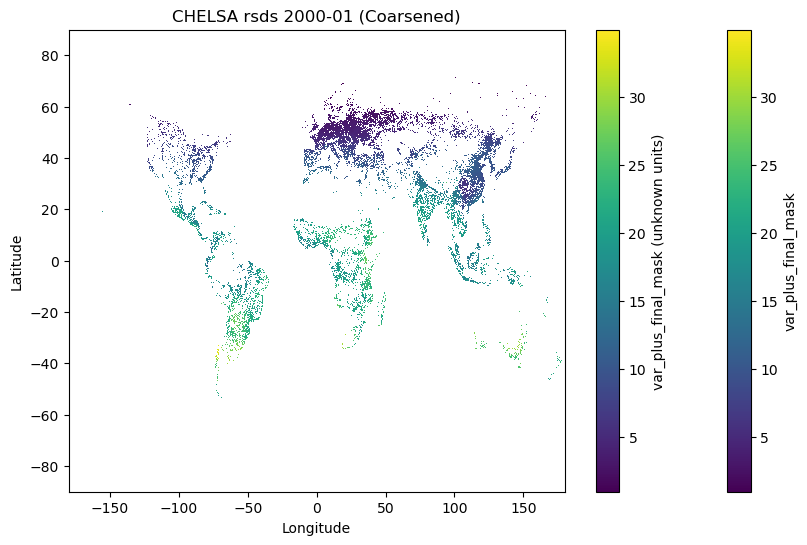


数据基本信息:
<xarray.Dataset> Size: 4GB
Dimensions:              (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref          int32 4B ...
  * lon                  (lon) float64 346kB -180.0 -180.0 ... 180.0 180.0
  * lat                  (lat) float64 173kB 90.0 89.99 89.98 ... -89.99 -90.0
    time                 datetime64[ns] 8B ...
Data variables:
    var_plus_final_mask  (lat, lon) float32 4GB nan nan nan nan ... nan nan nan


In [2]:
# 读取并可视化对齐后的气候数据
import matplotlib.pyplot as plt
import xarray as xr

# 读取NetCDF文件
file_path = r"D:\xarray\aligned\test_sum.nc"
ds = xr.open_dataset(file_path)

# 获取主要变量
var_name = list(ds.data_vars)[0]
data = ds[var_name]

# 计算并打印经度和纬度的分辨率
lon_res = abs(data.lon[1].values - data.lon[0].values)
lat_res = abs(data.lat[1].values - data.lat[0].values)
print(f"经度分辨率: {lon_res:}度")
print(f"纬度分辨率: {lat_res:}度")

# 使用coarse方法进行可视化（降低分辨率以加快绘图）
coarse_data = data.coarsen(lon=10, lat=10).mean()

# 创建可视化图
fig, ax = plt.subplots(figsize=(10, 6))
# 使用imshow或pcolormesh并保存返回的mappable对象
im = coarse_data.plot(ax=ax, cmap='viridis')
plt.title(f'CHELSA rsds 2000-01 (Coarsened)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# 使用已创建的mappable对象添加colorbar
plt.colorbar(im, label=f'{var_name} ({getattr(data, "units", "unknown units")})')
plt.show()

# 显示数据基本信息
print("\n数据基本信息:")
print(ds)

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm

def add_climate_files(file1_path, file2_path, output_path):
    """
    对两个气候数据文件进行加法操作
    
    Parameters:
    -----------
    file1_path : str
        第一个输入文件路径
    file2_path : str
        第二个输入文件路径
    output_path : str
        输出文件路径
    """
    # 设置chunk大小
    chunk_size = 500
    
    # 打开数据集，使用chunking
    with xr.open_dataset(file1_path, chunks={'lat': chunk_size, 'lon': chunk_size}) as ds1, \
         xr.open_dataset(file2_path, chunks={'lat': chunk_size, 'lon': chunk_size}) as ds2:
        
        # 获取变量名
        var1 = list(ds1.data_vars)[0]
        var2 = list(ds2.data_vars)[0]
        
        # 确保两个数据集具有相同的维度
        if not (ds1[var1].dims == ds2[var2].dims):
            raise ValueError("两个数据集必须具有相同的维度")
        
        # 执行加法操作
        result = ds1[var1] + ds2[var2]
        
        # 创建新的数据集
        ds_out = result.to_dataset(name=f"{var1}_plus_{var2}")
        
        # 设置编码
        encoding = {list(ds_out.data_vars)[0]: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_size, chunk_size)
        }}
        
        # 保存结果
        ds_out.to_netcdf(output_path, encoding=encoding)
        
        return output_path

def main():
    # 设置文件路径
    file1 = r"D:\xarray\aligned\CHELSA_rsds_2000_01_V.2.1.nc"
    file2 = r"D:\xarray\final_mask_1km_new.nc"
    output = r"D:\xarray\aligned\test_sum.nc"
    
    try:
        # 执行加法操作
        result_path = add_climate_files(file1, file2, output)
        print(f"✓ 加法操作完成，结果保存至: {result_path}")
        
        # 验证结果
        with xr.open_dataset(result_path) as ds:
            print("\n结果数据集信息:")
            print(ds)
            
    except Exception as e:
        print(f"× 处理过程中出错: {str(e)}")

if __name__ == "__main__":
    main()

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


✓ 加法操作完成，结果保存至: D:\xarray\aligned\test_sum.nc

结果数据集信息:
<xarray.Dataset> Size: 4GB
Dimensions:              (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref          int32 4B ...
  * lon                  (lon) float64 346kB -180.0 -180.0 ... 180.0 180.0
  * lat                  (lat) float64 173kB 90.0 89.99 89.98 ... -89.99 -90.0
    time                 datetime64[ns] 8B ...
Data variables:
    var_plus_final_mask  (lat, lon) float32 4GB ...


### 所有气候TIFF文件推广

    数据输入：
    源目录--->D:\xarray\pre-process\Climate_rsds
    数据输出：
    目标目录--->D:\xarray\aligned\rsds

#### 短波辐射数据批处理

In [3]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_rsds")
OUT_DIR  = Path(r"D:\xarray\aligned\rsds")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"

    # 2.1 读入时就分块
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .squeeze("band", drop=True)
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )

    # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="nearest")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    # 2.4 构造 Dataset 并分块
    var = da_masked.name or "var"
    ds  = da_masked.to_dataset(name=var) \
                   .chunk({"lat": chunk_lat, "lon": chunk_lon})

    # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
    encoding = {
        var: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_lat, chunk_lon)
        }
    }
    ds.to_netcdf(out_nc, encoding=encoding)

    # 2.6 关闭 & 回收
    ds.close()
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs: 100%|██████████| 240/240 [3:28:08<00:00, 52.04s/it]  

✅ All done! Aligned files are in: D:\xarray\aligned\rsds


#### 风速批处理

理论上应该有240个文件，这里少了8个，需要核查一下。

2008-2011年可能需要重新输出一下。

In [6]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_wind")
OUT_DIR  = Path(r"D:\xarray\aligned\wind")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果输出文件已经存在，跳过处理
    if out_nc.exists():
        continue

    # 2.1 读入时就分块
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .squeeze("band", drop=True)
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )

    # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="nearest")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    # 2.4 构造 Dataset 并分块
    var = da_masked.name or "var"
    ds  = da_masked.to_dataset(name=var) \
                   .chunk({"lat": chunk_lat, "lon": chunk_lon})

    # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
    encoding = {
        var: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_lat, chunk_lon)
        }
    }
    ds.to_netcdf(out_nc, encoding=encoding)

    # 2.6 关闭 & 回收
    ds.close()
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs:   0%|          | 0/232 [00:00<?, ?it/s]

Aligning TIFs: 100%|██████████| 232/232 [1:21:39<00:00, 21.12s/it]

✅ All done! Aligned files are in: D:\xarray\aligned\wind


#### 气温批处理

Number of bands: 1
Raster shape: (20880, 43200)
Raster data type: int32

In [ ]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_tas")
OUT_DIR  = Path(r"D:\xarray\aligned\tas")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"

    # 2.1 读入时就分块
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .squeeze("band", drop=True)
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )

    # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="linear")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    # 2.4 构造 Dataset 并分块
    var = da_masked.name or "var"
    ds  = da_masked.to_dataset(name=var) \
                   .chunk({"lat": chunk_lat, "lon": chunk_lon})

    # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
    encoding = {
        var: {
            "zlib": True,
            "complevel": 5,
            "chunksizes": (chunk_lat, chunk_lon)
        }
    }
    ds.to_netcdf(out_nc, encoding=encoding)

    # 2.6 关闭 & 回收
    ds.close()
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs:  62%|██████▏   | 148/240 [8:39:14<6:12:28, 242.92s/it]

## GMDP数据处理
欧洲数据。
10day分辨率的1KM数据分别选取了各年度四季度的一天。
season_days = {
    "spring": (3, 21),
    "summer": (6, 21),
    "autumn": (9, 23),
    "winter": (12, 21)
}
根据官方文档：
RT0-RT6的区别在可接受范围内（忽略差异）；共有82个文件，缺少2020年9月与12月的

D:\xarray\pre-process\Gross_productivity
D:\xarray\pre-process\Gross_productivity\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1
D:\xarray\pre-process\Gross_productivity\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1\c_gls_GDMP_200003310000_GLOBE_VGT_V2.0.1.nc

In [2]:
from pathlib import Path
import xarray as xr
def collect_gdmp_files(base_dir):
    """
    收集所有GDMP文件夹中的NC文件路径
    
    Parameters:
    -----------
    base_dir : str
        基础目录路径
    
    Returns:
    --------
    list
        包含所有NC文件绝对路径的列表
    """
    base_path = Path(base_dir)
    
    # 获取所有以c_gls_GDMP开头的文件夹
    gdmp_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('c_gls_GDMP')]
    
    # 收集所有NC文件路径
    nc_files = []
    for folder in gdmp_folders:
        nc_files.extend(folder.glob('*.nc'))
    
    # 转换为绝对路径
    nc_files = [str(f.absolute()) for f in nc_files]
    
    return nc_files


base_dir = r"D:\xarray\pre-process\Gross_productivity"

nc_files = collect_gdmp_files(base_dir)
    
print(nc_files)


['D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201506300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_2

In [9]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
OUT_DIR  = Path(r"D:\xarray\aligned\gdmp")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

for fp in tqdm(nc_files, desc="Aligning TIFs"):
    file_path = Path(fp)
    out_nc = OUT_DIR / f"{file_path.stem}.nc"
    
    try:
        # 对于NetCDF文件的特殊处理
        ds = xr.open_dataset(str(file_path), chunks={'lat': chunk_lat, 'lon': chunk_lon})
        
        # 获取主要变量名（通常是第二个数据变量，第一个可能是坐标或辅助变量）
        var_names = list(ds.data_vars)
        var_name = var_names[0] if len(var_names) == 1 else var_names[1]
        
        # 获取数据数组
        da = ds[var_name]
        
        # 处理可能存在的时间维度
        if 'time' in da.dims:
            da = da.isel(time=0)
            
        # 确保坐标系统正确
        if 'lon' in da.dims and 'lat' in da.dims:
            # 使用双线性插值进行重采样（对于连续数据如GDMP更合适）
            da_al = da.interp(lon=lon, lat=lat, method="linear")
            
            # 应用陆地掩膜
            da_masked = da_al.where(mask)
            
            # 构造输出数据集
            out_ds = da_masked.to_dataset(name=var_name)
            
            # 设置压缩和分块参数
            encoding = {
                var_name: {
                    "zlib": True,
                    "complevel": 5,
                    "chunksizes": (chunk_lat, chunk_lon),
                    "_FillValue": np.nan  # 使用NaN作为填充值
                }
            }
            
            # 保存为NetCDF文件
            out_ds.to_netcdf(out_nc, encoding=encoding)
            out_ds.close()
        else:
            print(f"警告: {file_path.name} 缺少经纬度坐标，跳过处理")
            
    except Exception as e:
        print(f"处理 {file_path.name} 时出错: {str(e)}")
    finally:
        # 清理内存
        if 'ds' in locals():
            ds.close()
        if 'da_al' in locals():
            da_al = None
        if 'da' in locals():
            da = None
        if 'out_ds' in locals():
            out_ds = None
        gc.collect()

print("✅ 所有文件处理完成! 对齐后的文件保存在:", OUT_DIR)


Aligning TIFs:   0%|          | 0/82 [00:00<?, ?it/s]

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Aligning TIFs:   1%|          | 1/82 [03:01<4:05:08, 181.59s/it]c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dat

✅ 所有文件处理完成! 对齐后的文件保存在: D:\xarray\aligned\gdmp


## 多波段社会经济TIFF处理

In [ ]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = r"D:\xarray\aligned\master_land_0509.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process")
OUT_DIR  = Path(r"D:\xarray\aligned\social")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
for fp in tqdm(list(SRC_DIR.glob("*.tif")), desc="Aligning TIFs"):
    
    info = get_tiff_info(fp)
    da = (
        rxr.open_rasterio(fp, masked=True,
                          chunks={"x": chunk_lon, "y": chunk_lat})
          .rio.set_spatial_dims("x", "y", inplace=False)
          .rename({"x": "lon", "y": "lat"})
    )
        # 2.2 按模板经纬度插值对齐（nearest 保持离散特征）
    da_al = da.interp(lon=lon, lat=lat, method="nearest")

    # 2.3 应用模板布尔掩膜
    da_masked = da_al.where(mask)

    if info['bands'] > 1:
        for band_idx in range(info['bands']):
            # 获取波段名称
            band_name = info['band_names'][band_idx]
            out_nc = OUT_DIR / f"{Path(fp).stem}_{band_name}.nc"
            
            if out_nc.exists():
                continue

            # 选择当前波段
            da_band = da_masked.isel(band=band_idx)
            
            # 构造 Dataset 并分块
            ds = da_band.to_dataset(name=band_name) \
                        .chunk({"lat": chunk_lat, "lon": chunk_lon})

            # 写出 NetCDF
            encoding = {
                band_name: {
                    "zlib": True,
                    "complevel": 5,
                    "chunksizes": (chunk_lat, chunk_lon)
                }
            }
            ds.to_netcdf(out_nc, encoding=encoding)
            ds.close()
    else:
        # 单波段处理：直接保存
        out_nc = OUT_DIR / f"{Path(fp).stem}.nc"
        if out_nc.exists():
            continue

        # 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds = da_masked.to_dataset(name=var) \
                      .chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 写出 NetCDF
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        ds.to_netcdf(out_nc, encoding=encoding)
        ds.close()

    # 2.6 关闭 & 回收
    da_al = None
    da    = None
    gc.collect()

print("✅ All done! Aligned files are in:", OUT_DIR)


## 补充数据处理